# Invoke Bedrock model for code generation

## Architecture

![](./images/bedrock-code-gen.png)

### Persona

You are Moe, a Data Analyst, at AnyCompany. The company wants to understand its sales performance for different products for different products over the past year. You have been provided a dataset named sales.csv. The dataset contains the following columns:

- Date (YYYY-MM-DD) format
- Product_ID (unique identifer for each product)
- Price (price at which each product was sold)
- Units sold

## Setup


In [ ]:

# Importing necessary libraries to work with AWS, files, and environment variables
import json  # For working with JSON data
import os  # For interacting with the operating system (e.g., file paths)
import sys  # For modifying system paths

# Importing Boto3 (AWS SDK for Python) and botocore (handles low-level AWS interactions)
import boto3
import botocore

# Adding the parent directory to the system path so we can import files from there
module_path = ".."  # This points to the parent directory
sys.path.append(os.path.abspath(module_path))  # Adds the parent directory to the search path for modules

# Create a connection to Amazon Bedrock service using the Boto3 client
# 'bedrock-runtime' specifies the service we want to connect to
# The region_name is fetched from the environment variable AWS_DEFAULT_REGION
boto3_bedrock = boto3.client(
    'bedrock-runtime',  # Service name: Bedrock
    region_name=os.environ.get("AWS_DEFAULT_REGION", None)  # AWS region, if available from environment settings
)

print("done successfully")

done successfully


## Generate sample sales.csv data for this demo



In [4]:
# create sales.csv file
import csv

data = [
    ["date", "product_id", "price", "units_sold"],
    ["2023-01-01", "P001", 50, 20],
    ["2023-01-02", "P002", 60, 15],
    ["2023-01-03", "P001", 50, 18],
    ["2023-01-04", "P003", 70, 30],
    ["2023-01-05", "P001", 50, 25],
    ["2023-01-06", "P002", 60, 22],
    ["2023-01-07", "P003", 70, 24],
    ["2023-01-08", "P001", 50, 28],
    ["2023-01-09", "P002", 60, 17],
    ["2023-01-10", "P003", 70, 29],
    ["2023-02-11", "P001", 50, 23],
    ["2023-02-12", "P002", 60, 19],
    ["2023-02-13", "P001", 50, 21],
    ["2023-02-14", "P003", 70, 31],
    ["2023-03-15", "P001", 50, 26],
    ["2023-03-16", "P002", 60, 20],
    ["2023-03-17", "P003", 70, 33],
    ["2023-04-18", "P001", 50, 27],
    ["2023-04-19", "P002", 60, 18],
    ["2023-04-20", "P003", 70, 32],
    ["2023-04-21", "P001", 50, 22],
    ["2023-04-22", "P002", 60, 16],
    ["2023-04-23", "P003", 70, 34],
    ["2023-05-24", "P001", 50, 24],
    ["2023-05-25", "P002", 60, 21]
]

# Write data to sales.csv
with open('sales.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(data)

print("sales.csv has been created!")

sales.csv has been created!


## Build the prompt

In [5]:
# Create the prompt
# Analyzing sales

prompt_data = """

Human: You have a CSV, sales.csv, with columns:
- date (YYYY-MM-DD)
- product_id
- price
- units_sold

Create a python program to analyze the sales data from a CSV file. The program should be able to read the data, and determine below:

- Total revenue for the year
- The product with the highest revenue
- The date with the highest revenue
- Visualize monthly sales using a bar chart

Ensure the code is syntactically correct, bug-free, optimized, not span multiple lines unnessarily, and prefer to use standard libraries. Return only python code without any surrounding text, explanation or context.

Assistant:
"""

## Construct the request payload

In [6]:
# Claude - Body Syntex
body = json.dumps({
    "anthropic_version": "bedrock-2023-05-31",
    "messages": [
        {"role": "user", "content": prompt_data}
    ],
    "max_tokens": 4096,
    "temperature": 0.5,
    "top_k": 250,
    "top_p": 0.5,
    "stop_sequences": ["\n\nHuman:"]
})

## Invoke the model

## (Optional) Run the code to check it works

In [ ]:

# Send request to Claude 3.7 Sonnet

try:
    response = boto3_bedrock.invoke_model(                     # Call the Bedrock Invoke API to run the model
        modelId="us.anthropic.claude-3-7-sonnet-20250219-v1:0",             # The model ID for Claude 3.7 Sonnet
        body=body,                                # JSON request body created earlier
        accept="application/json",                       # Expected response format
        contentType="application/json"                   # Content type of the request body
    )
    response_body = json.loads(response.get('body').read())  # Read and parse the model's JSON response

    # Extract and display the response text
    claude_response_summary = response_body["content"][0]["text"]     # Extract the actual summary text from the response
    print(claude_response_summary)
    #display_response(claude_summary, "Claude 3.7 Sonnet (Invoke Model API)")  # Display formatted output

except botocore.exceptions.ClientError as error:             # Handle AWS API errors
    if error.response['Error']['Code'] == 'AccessDeniedException':
        # Provide helpful message for access issues
        print(f"\x1b[41m{error.response['Error']['Message']}\
            \nTo troubleshoot this issue please refer to the following resources.\
            \nhttps://docs.aws.amazon.com/IAM/latest/UserGuide/troubleshoot_access-denied.html\
            \nhttps://docs.aws.amazon.com/bedrock/latest/userguide/security-iam.html\x1b[0m\n")
    else:
        raise error

```python
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

def analyze_sales(file_path):
    # Read the CSV file
    df = pd.read_csv(file_path)
    
    # Convert date to datetime
    df['date'] = pd.to_datetime(df['date'])
    
    # Calculate revenue
    df['revenue'] = df['price'] * df['units_sold']
    
    # Total revenue for the year
    total_revenue = df['revenue'].sum()
    
    # Product with highest revenue
    product_revenue = df.groupby('product_id')['revenue'].sum()
    highest_revenue_product = product_revenue.idxmax()
    highest_product_revenue = product_revenue.max()
    
    # Date with highest revenue
    date_revenue = df.groupby('date')['revenue'].sum()
    highest_revenue_date = date_revenue.idxmax()
    highest_date_revenue = date_revenue.max()
    
    # Monthly sales visualization
    df['month'] = df['date'].dt.strftime('%Y-%m')
    monthly_revenue = df.groupby('month')['revenue'].sum()
    
    plt.figure(figsize=(12, 6))


Total Revenue for the Year: $35490.00
Product with Highest Revenue: P003 ($14910.00)
Date with Highest Revenue: 2023-04-23 ($2380.00)
Monthly sales chart saved as 'monthly_sales.png'


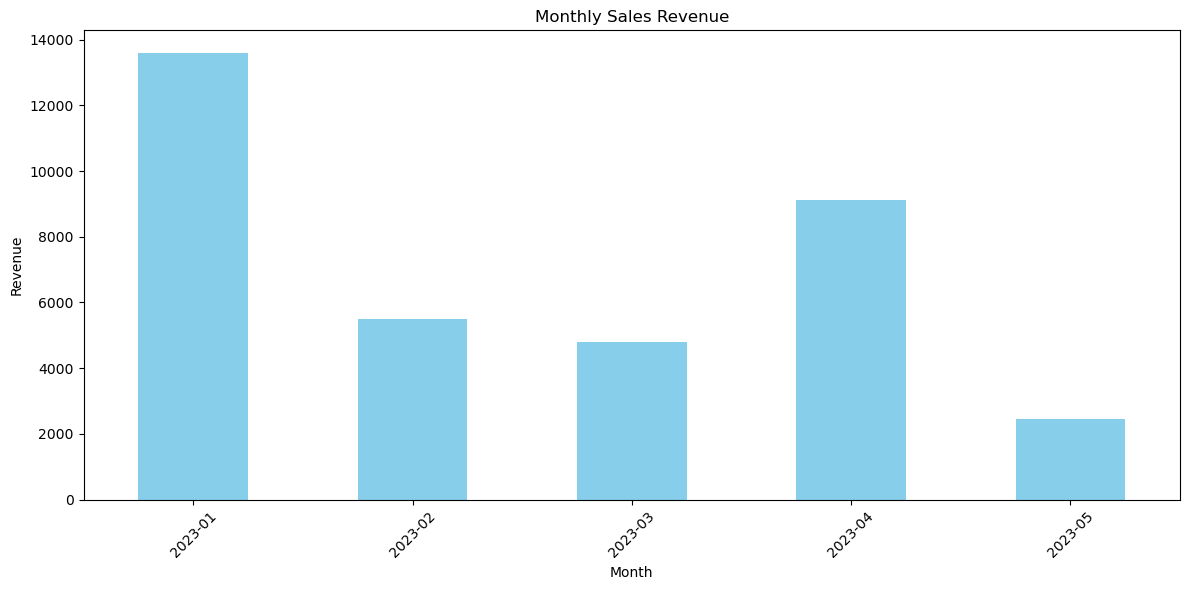

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

def analyze_sales(file_path):
    # Read the CSV file
    df = pd.read_csv(file_path)
    
    # Convert date to datetime
    df['date'] = pd.to_datetime(df['date'])
    
    # Calculate revenue
    df['revenue'] = df['price'] * df['units_sold']
    
    # Total revenue for the year
    total_revenue = df['revenue'].sum()
    
    # Product with highest revenue
    product_revenue = df.groupby('product_id')['revenue'].sum()
    highest_revenue_product = product_revenue.idxmax()
    highest_product_revenue = product_revenue.max()
    
    # Date with highest revenue
    date_revenue = df.groupby('date')['revenue'].sum()
    highest_revenue_date = date_revenue.idxmax()
    highest_date_revenue = date_revenue.max()
    
    # Monthly sales visualization
    df['month'] = df['date'].dt.strftime('%Y-%m')
    monthly_revenue = df.groupby('month')['revenue'].sum()
    
    plt.figure(figsize=(12, 6))
    monthly_revenue.plot(kind='bar', color='skyblue')
    plt.title('Monthly Sales Revenue')
    plt.xlabel('Month')
    plt.ylabel('Revenue')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('monthly_sales.png')
    
    # Print results
    print(f"Total Revenue for the Year: ${total_revenue:.2f}")
    print(f"Product with Highest Revenue: {highest_revenue_product} (${highest_product_revenue:.2f})")
    print(f"Date with Highest Revenue: {highest_revenue_date.strftime('%Y-%m-%d')} (${highest_date_revenue:.2f})")
    print("Monthly sales chart saved as 'monthly_sales.png'")

#if __name__ == "__main__":

analyze_sales("sales.csv")

    